<a href="https://colab.research.google.com/github/chi-hun/kaggle/blob/main/Pizza_or_Not_Pizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pizza or Not Pizza
https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import PIL
import matplotlib.pyplot as plt
!pip install split-folders
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 데이터 탐색

pizza files : 983, not files : 922


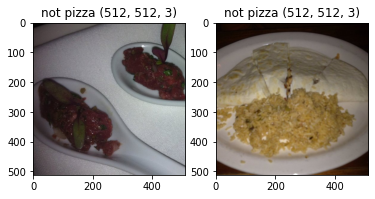

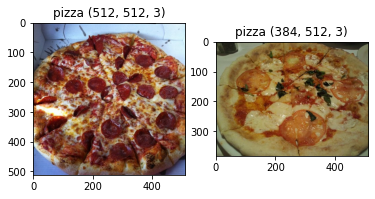

In [ ]:
path_not = '/content/drive/MyDrive/Colab Notebooks/kaggle/pizza or not pizza(data)/not_pizza'
path_pizza = '/content/drive/MyDrive/Colab Notebooks/kaggle/pizza or not pizza(data)/pizza'
list_file_not = sorted(os.listdir(path_not))
list_file_pizza = sorted(os.listdir(path_pizza))
print(f'pizza files : {len(list_file_pizza)}, not files : {len(list_file_not)}')
for i in range(2):
    plt.subplot(1,2,i+1)
    test_image = PIL.Image.open(os.path.join(path_not,list_file_not[i]))
    plt.title(f'not pizza {np.array(test_image).shape}')
    plt.imshow(test_image)
plt.show()
for i in range(2):
    plt.subplot(1,2,i+1)
    test_image = PIL.Image.open(os.path.join(path_pizza,list_file_pizza[i]))
    plt.title(f'pizza {np.array(test_image).shape}')
    plt.imshow(test_image)
plt.show()

# 데이터 셋

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/kaggle/pizza or not pizza(data)'
splitfolders.ratio(path, output='/content/drive/MyDrive/Colab Notebooks/kaggle/pizza or not pizza(data)', seed=42, ratio=(0.8, 0.2), group_prefix=None)

Copying files: 1905 files [00:43, 43.43 files/s] 


In [6]:
img_size = 350
train_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/pizza or not pizza(data)/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                               image_size=(img_size,img_size),
                                                               validation_split = 0.2,
                                                               subset='training',
                                                               batch_size=32,
                                                               seed = 42)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                               image_size=(img_size,img_size),
                                                               validation_split = 0.2,
                                                               subset='validation', 
                                                             batch_size = 32,
                                                             seed=42)

Found 1523 files belonging to 3 classes.
Using 1219 files for training.
Found 1523 files belonging to 3 classes.
Using 304 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['.ipynb_checkpoints', 'not_pizza', 'pizza']

In [8]:
test_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/pizza or not pizza(data)/val'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                              image_size = (img_size, img_size),
                                                              shuffle  = False,
                                                              batch_size = 32)

Found 382 files belonging to 3 classes.


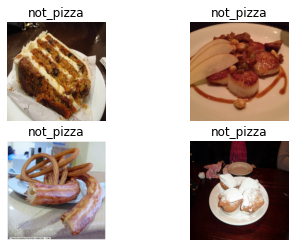

In [9]:
for i, j in train_ds.take(1):
    for k in range(4):
        plt.subplot(2,2,k+1)
        plt.title(class_names[j[k]])
        plt.imshow(i[k].numpy().astype('uint8'))
        plt.axis(False)
    plt.show()


# 모델링(직접 합성곱)

In [10]:
def model_make1(img_size):
    inputs = tf.keras.Input(shape=(img_size,img_size,3))
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = layers.experimental.preprocessing.RandomFlip('horizontal')(x)
    x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
    x = layers.experimental.preprocessing.RandomZoom(0.1)(x)

    x = layers.Conv2D(128, 3, padding='same', activation = 'relu')(x)
    x = layers.Conv2D(128, 3, activation = 'relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation = 'relu')(x)
    x = layers.Conv2D(64, 3, activation = 'relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(32, 3, padding='same', activation = 'relu')(x)
    x = layers.Conv2D(32, 3, activation = 'relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.1)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [34]:
model = model_make1(img_size)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 350, 350, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 350, 350, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 350, 350, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 350, 350, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 350, 350, 128)     3584      
                                                           

In [35]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
39/39 [==============================] - 51s 1s/step - loss: 1.3690 - accuracy: 0.3905 - val_loss: 0.9889 - val_accuracy: 0.5099
Epoch 2/10
39/39 [==============================] - 49s 1s/step - loss: 1.1534 - accuracy: 0.4487 - val_loss: 0.9423 - val_accuracy: 0.5493
Epoch 3/10
39/39 [==============================] - 49s 1s/step - loss: 1.0208 - accuracy: 0.5275 - val_loss: 0.8451 - val_accuracy: 0.5263
Epoch 4/10
39/39 [==============================] - 48s 1s/step - loss: 0.9419 - accuracy: 0.5242 - val_loss: 0.9788 - val_accuracy: 0.5559
Epoch 5/10
39/39 [==============================] - 48s 1s/step - loss: 0.8871 - accuracy: 0.5521 - val_loss: 1.0319 - val_accuracy: 0.5757
Epoch 6/10
39/39 [==============================] - 48s 1s/step - loss: 0.8415 - accuracy: 0.5611 - val_loss: 1.8245 - val_accuracy: 0.5724
Epoch 7/10
39/39 [==============================] - 47s 1s/step - loss: 0.7826 - accuracy: 0.6030 - val_loss: 0.8412 - val_accuracy: 0.6480
Epoch 8/10
39/39 [==

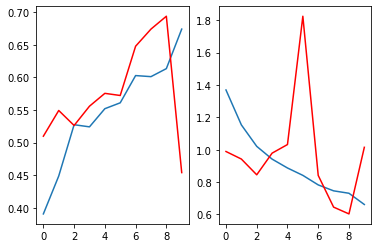

In [37]:
plt.subplot(1,2,1)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'], '-r')
plt.subplot(1,2,2)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'], '-r')

In [44]:
anser = []
for i, j in test_ds.take(40):
    anser += (list(j.numpy()))
anser = np.array(anser)

In [38]:
pre = model.predict(test_ds)
pre = np.argmax(pre, axis = 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [51]:
sum(pre == anser)/len(pre)

0.4973821989528796

# 모델링(mobilenet_v2, 학습 X)

In [24]:
prepro = tf.keras.applications.mobilenet_v3.preprocess_input
base_model = tf.keras.applications.MobileNetV3Small(input_shape =(img_size,img_size,3),
                                                weights = 'imagenet',
                                                include_top = False)
base_model.trainable = False

In [25]:
def model_make2(prepro, base_model, input_shape):
    inputs = layers.Input(shape = input_shape)
    x = layers.experimental.preprocessing.RandomFlip('horizontal')(inputs)
    x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
    x = layers.experimental.preprocessing.RandomZoom(0.1)(x)
    x = prepro(x)
    x = base_model(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [26]:
model = model_make2(prepro, base_model, (img_size,img_size,3))
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 350, 350, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 350, 350, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 350, 350, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 11, 11, 576)      939120    
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 576)              0   

In [29]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [30]:
his = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
39/39 [==============================] - 185s 4s/step - loss: 0.7349 - accuracy: 0.6891 - val_loss: 0.5498 - val_accuracy: 0.8684
Epoch 2/10
39/39 [==============================] - 78s 2s/step - loss: 0.3675 - accuracy: 0.8901 - val_loss: 0.3296 - val_accuracy: 0.9145
Epoch 3/10
39/39 [==============================] - 93s 2s/step - loss: 0.2853 - accuracy: 0.9229 - val_loss: 0.2299 - val_accuracy: 0.9375
Epoch 4/10
39/39 [==============================] - 80s 2s/step - loss: 0.2224 - accuracy: 0.9311 - val_loss: 0.2026 - val_accuracy: 0.9441
Epoch 5/10
39/39 [==============================] - 92s 2s/step - loss: 0.2047 - accuracy: 0.9434 - val_loss: 0.1657 - val_accuracy: 0.9408
Epoch 6/10
39/39 [==============================] - 77s 2s/step - loss: 0.1825 - accuracy: 0.9483 - val_loss: 0.1840 - val_accuracy: 0.9342
Epoch 7/10
39/39 [==============================] - 75s 2s/step - loss: 0.1700 - accuracy: 0.9418 - val_loss: 0.1880 - val_accuracy: 0.9474
Epoch 8/10
39/39 [=

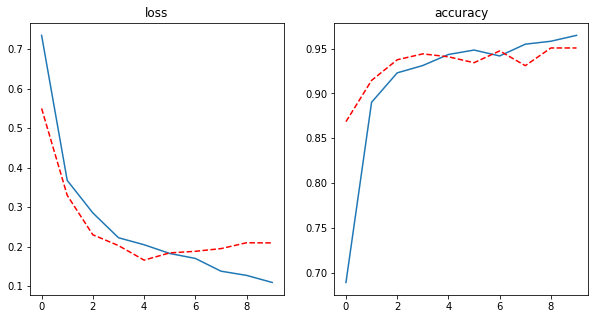

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('loss')
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'],'--r')
plt.subplot(1,2,2)
plt.title('accuracy')
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'], '--r')
plt.show()

In [45]:
pre = model.predict(test_ds)
pre = np.argmax(pre, axis = 1)
pre

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [48]:
anser = []
for i, j in test_ds.take(40):
    anser += list(j.numpy())
anser = np.array(anser)
acc = round((np.sum(anser == pre)/len(anser))*100, 2)
print(f'테스트 정확도는 {acc}입니다')

테스트 정확도는 92.93입니다
